### Experiment 1 - Checking how a GAN performs when discriminator is converted to fully convolutional

This is to check how the vanilla GAN framework performs in a 'DC-GAN' setting after the discriminator is changed from fully convolutional layers are changed to densely connected layers. First we will train a standard DCGAN. In the second experiment, we will change the discriminator tp be fully convolutional to look at the effect.

In [1]:
import numpy as np

import torch
from torch.autograd import Variable

import torch.nn as nn

# import activation functions
import torch.nn.functional as F

# import optimization functions
import torch.optim as optim

# torch vision functions
import torchvision


import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels
reload(sys.modules[loadDataset.__module__])


import matplotlib
import matplotlib.pyplot as plt

import time

Load a standard dataset for experiments. MNIST and SVHN 

In [2]:
classes = [i for i in range(10)]
instances = [7000 for i in range(10)]
batchSize = 256

mnist_dataset = loadDataset('MNIST', classes, instances, 'train')
mnist_dataloader = torch.utils.data.DataLoader(mnist_dataset, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last=True)

svhn_dataset = loadDataset('SVHN', classes, instances, 'train')
svhn_dataloader = torch.utils.data.DataLoader(mnist_dataset, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last=True)

Let's set the parameters for training

In [3]:
numInputChannels = 100
numGenFilter = 64
numDiscFilter = 64
numOutputChannels = 1


learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32
numClasses = 10

In [4]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    


    plt.show()

### Sub-Experiment 1

First, train a fully convolutional generator and fully convolutional discriminator.

<img src="./images/DCGAN.png">

Generator :(100) $\rightarrow$ (512,4,4) $\rightarrow$ (256,8,8) $\rightarrow$ (128,16,16) $\rightarrow$ (1,32,32)

Discriminator :(1,32,32) $\rightarrow$ (128,16,16) $\rightarrow$ (256,8,8) $\rightarrow$ (512,4,4) $\rightarrow$ 1 

In [7]:
def train(trainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numInputChannels, numGenFilter, numOutputChannels)
    D = Discriminator(numOutputChannels, numDiscFilter)
    
    #initialize the weights here
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      1,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numInputChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    # to check the formation of image, we define a fixed noise vector
    fixedNoise = torch.FloatTensor(batchSize,
                                   numInputChannels,
                                   1,
                                   1)
    fixedNoise.normal_(0,1)
    

    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        
    fixedNoiseV = Variable(fixedNoise)
    
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts   
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(trainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataLabel = data
            if cuda:
                dataInstance = dataInstance.cuda()
            
            #print discRealInput.shape, dataInstance.shape
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            
            discRealInputV = Variable(discRealInput)
            discRealLabelV = Variable(discRealLabel)
            
            discRealOutput = D(discRealInputV)
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            discFakeInput.normal_(0,1)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            genFakeOutput = G(discFakeInputV)
            
            # detach the graph prior to D. So what weights in G do not get updated
            discFakeOutput = D(genFakeOutput.detach())
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutput)
            genLossFake = lossFunction(discFakeOutput, discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/30] time: 50.92, loss_d: 0.374, loss_g: 4.057
Epoch : [2/30] time: 50.48, loss_d: 0.454, loss_g: 2.973
Epoch : [3/30] time: 50.47, loss_d: 0.596, loss_g: 2.395
Epoch : [4/30] time: 50.46, loss_d: 0.614, loss_g: 2.088
Epoch : [5/30] time: 50.46, loss_d: 0.782, loss_g: 1.844
Epoch : [6/30] time: 50.41, loss_d: 0.716, loss_g: 1.920
Epoch : [7/30] time: 50.43, loss_d: 0.631, loss_g: 2.197
Epoch : [8/30] time: 50.43, loss_d: 0.585, loss_g: 2.279
Epoch : [9/30] time: 50.38, loss_d: 0.466, loss_g: 2.644
Epoch : [10/30] time: 50.37, loss_d: 0.450, loss_g: 2.847
Epoch : [11/30] time: 50.40, loss_d: 0.528, loss_g: 2.806
Epoch : [12/30] time: 50.39, loss_d: 0.361, loss_g: 3.043
Epoch : [13/30] time: 50.43, loss_d: 0.446, loss_g: 3.150
Epoch : [14/30] time: 50.41, loss_d: 0.178, loss_g: 3.653
Epoch : [15/30] time: 50.42, loss_d: 0.673, loss_g: 2.391
Epoch : [16/30] time: 50.41, loss_d: 0.335, loss_g: 3.593
Epoch : [17/30] time: 50.40, loss_d: 0.249, loss_g: 3.602
Epoch : [18/30] time: 5

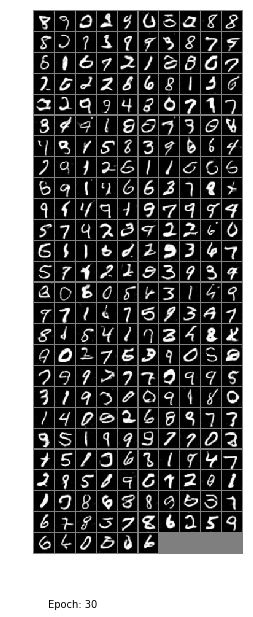

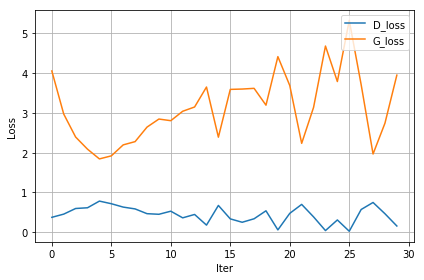

In [8]:
from model import Generator, Discriminator

train(mnist_dataloader, epochs=30)

### Sub-Experiment 2

Now, train a fully convolutional generator and densley connected discriminator.

<img src="./images/GAN_disc.png"  >

Generator :(100) $\rightarrow$ (512,4,4) $\rightarrow$ (256,8,8) $\rightarrow$ (128,16,16) $\rightarrow$ (1,32,32)

Discriminator :1024 $\rightarrow$ 1024 $\rightarrow$ 512 $\rightarrow$ 256  $\rightarrow$ 128  $\rightarrow$ 1

In [7]:
def train(trainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numInputChannels, numGenFilter, numOutputChannels)
    D = Discriminator(numOutputChannels)
    
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      1,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numInputChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    # to check the formation of image, we define a fixed noise vector
    fixedNoise = torch.FloatTensor(batchSize,
                                   numInputChannels,
                                   1,
                                   1)
    fixedNoise.normal_(0,1)
    
    
    
    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        
    fixedNoiseV = Variable(fixedNoise)
    
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts    
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(trainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataLabel = data
            if cuda:
                dataInstance = dataInstance.cuda()
            
            #print discRealInput.shape, dataInstance.shape
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            
            discRealInputV = Variable(discRealInput)
            discRealLabelV = Variable(discRealLabel)
            
            discRealOutput = D(discRealInputV.view(batchSize,-1))
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            discFakeInput.normal_(0,1)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            genFakeOutput = G(discFakeInputV)
            genFakeOutput = genFakeOutput.view(batchSize,-1)
            
            # detach the graph prior to D. So what weights in G do not get updated
            discFakeOutput = D(genFakeOutput.detach())
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutput)
            genLossFake = lossFunction(discFakeOutput, discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/30] time: 18.47, loss_d: 1.131, loss_g: 0.845
Epoch : [2/30] time: 16.54, loss_d: 0.649, loss_g: 1.319
Epoch : [3/30] time: 16.96, loss_d: 0.328, loss_g: 1.960
Epoch : [4/30] time: 16.97, loss_d: 0.210, loss_g: 2.477
Epoch : [5/30] time: 17.00, loss_d: 0.170, loss_g: 2.677
Epoch : [6/30] time: 16.97, loss_d: 0.136, loss_g: 2.994
Epoch : [7/30] time: 16.93, loss_d: 0.111, loss_g: 3.147
Epoch : [8/30] time: 16.92, loss_d: 0.098, loss_g: 3.302
Epoch : [9/30] time: 16.96, loss_d: 0.062, loss_g: 3.691
Epoch : [10/30] time: 16.95, loss_d: 0.046, loss_g: 4.018
Epoch : [11/30] time: 16.96, loss_d: 0.053, loss_g: 4.157
Epoch : [12/30] time: 17.00, loss_d: 0.046, loss_g: 4.218
Epoch : [13/30] time: 17.02, loss_d: 0.103, loss_g: 3.986
Epoch : [14/30] time: 17.10, loss_d: 0.086, loss_g: 3.912
Epoch : [15/30] time: 16.94, loss_d: 0.281, loss_g: 2.841
Epoch : [16/30] time: 16.96, loss_d: 0.145, loss_g: 3.264
Epoch : [17/30] time: 17.04, loss_d: 0.086, loss_g: 3.829
Epoch : [18/30] time: 1

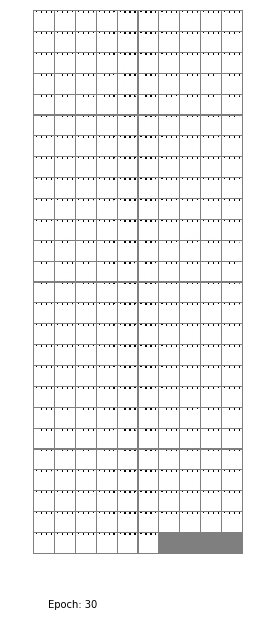

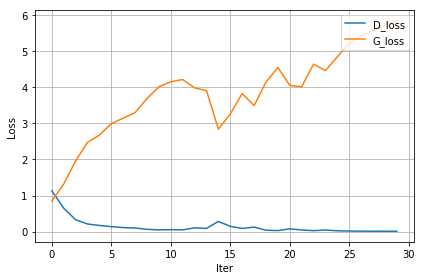

In [6]:
from model_alt import Generator, Discriminator

train(mnist_dataloader, epochs=30)

### Sub-Experiment 3 

Now, train aconditional GAN with fully convolutional generator and fully convolutional discriminator.

<img src="./images/cDCGAN.png"  >

                 
Generator : (100)+(10)   $\rightarrow$ (256,4,4)+(256,4,4)  $\rightarrow$ (512,4,4) $\rightarrow$ (256,8,8) $\rightarrow$ (128,16,16) $\rightarrow$ (1,32,32) 


Discriminator : (1,32,32)+(10,32,32) $\rightarrow$ (64,16,16)+(64,16,16) $\rightarrow$ (256,8,8) $\rightarrow$ (512,4,4)  $\rightarrow$  1

In [1]:
# Additional parameters to be defined for class conditional GAN 
numClasses = 10

In [7]:
def getProbDist(primaryInstanceList):
    '''
    probability distribution over primaryInstances
    '''
    probList = []
    sumList = float(sum(primaryInstanceList))
    for i, item in enumerate(primaryInstanceList):
        probList.append(item/sumList)
    return probList

In [8]:
def train(trainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numInputChannels, numClasses, numGenFilter, numOutputChannels)
    D = Discriminator(numOutputChannels, numClasses, numDiscFilter)
    
    #initialize weights 
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      1,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numInputChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    discRealInputClass = torch.zeros(batchSize,
                                      numClasses,
                                      imageSize,
                                      imageSize)
    discFakeInputClass = torch.zeros(batchSize,
                                      numClasses,
                                      1,
                                      1)    
    
    

    # to check the formation of image, we define a fixed noise vector
    numElementsNeededPerClass = 10
    
    fixedNoise = torch.randn(numElementsNeededPerClass*numClasses,
                             numInputChannels,
                             1,
                             1)
    
    # class from which the GAN should output a distribution
    fixedNoiseClass = torch.zeros(numElementsNeededPerClass*numClasses,
                                  numClasses,
                                  1,
                                  1)
    
    classIndex = torch.zeros(numElementsNeededPerClass,1)
    for i in range(numClasses-1):
        temp = torch.ones(numElementsNeededPerClass,1)+i
        classIndex = torch.cat([classIndex, temp], 0)
    
    fixedNoiseClass = fixedNoiseClass.squeeze().scatter_(1, classIndex.type(torch.LongTensor), 1)
    fixedNoiseClass = fixedNoiseClass.view(-1,
                                           numClasses,
                                           1,
                                           1)
    
    
    # can take the oneHot representation to feed into generator directly from here
    oneHotGen = torch.zeros(numClasses, numClasses)
    oneHotGen = oneHotGen.scatter_(1, torch.LongTensor([i for i in range(numClasses)]).view(numClasses,1), 1).view(numClasses, numClasses, 1, 1)
    
    # can take the oneHot representation to feed into discriminator directly from here
    oneHotDisc = torch.zeros([numClasses, numClasses, imageSize, imageSize])
    for i in range(numClasses):
        oneHotDisc[i,i,:,:] = 1
      
    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discRealInputClass = discRealInputClass.cuda()
        discFakeInputClass = discFakeInputClass.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        fixedNoiseClass = fixedNoiseClass.cuda()
        
        
        
    fixedNoiseV = Variable(fixedNoise)
    fixedNoiseClassV = Variable(fixedNoiseClass)

    # loggers
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(trainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataClass = data
            
            # one-hot encoding for discriminator class input
            dataClass = oneHotDisc[dataClass]
            
            if cuda:
                dataInstance = dataInstance.cuda()
                dataClass = dataClass.cuda()
            
            
            #print discRealInput.shape, dataInstance.shape
            
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            discRealInputClass.copy_(dataClass)

            discRealInputV = Variable(discRealInput)
            discRealInputClassV = Variable(discRealInputClass)
            discRealLabelV = Variable(discRealLabel)
            
            discRealOutput = D(discRealInputV,
                               discRealInputClassV)
            
            
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            #  p=getProbDist(primaryInstanceList)
            dataFakeClass = torch.from_numpy(np.random.choice(numClasses, batchSize))
            discFakeInputClass = oneHotDisc[dataFakeClass]
            genFakeInputClass = oneHotGen[dataFakeClass]
            
            if cuda:
                discFakeInputClass = discFakeInputClass.cuda()
                genFakeInputClass = genFakeInputClass.cuda()

                
            discFakeInput.normal_(0,1)
            
            discFakeInputClassV= Variable(discFakeInputClass)
            genFakeInputClassV = Variable(genFakeInputClass)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            
            genFakeOutput = G(discFakeInputV,
                              genFakeInputClassV)
            
            # detach the graph prior to D. So what weights in G do not get updated
            discFakeOutput = D(genFakeOutput.detach(),
                               discFakeInputClassV)
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutput,
                               discFakeInputClassV)
            
            genLossFake = lossFunction(discFakeOutput, 
                                       discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV,
                 fixedNoiseClassV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/30] time: 52.24, loss_d: 0.579, loss_g: 3.334
Epoch : [2/30] time: 53.70, loss_d: 0.524, loss_g: 2.929
Epoch : [3/30] time: 53.74, loss_d: 0.611, loss_g: 2.542
Epoch : [4/30] time: 53.64, loss_d: 0.847, loss_g: 1.874
Epoch : [5/30] time: 53.88, loss_d: 1.063, loss_g: 1.474
Epoch : [6/30] time: 53.70, loss_d: 1.076, loss_g: 1.394
Epoch : [7/30] time: 53.71, loss_d: 1.079, loss_g: 1.339
Epoch : [8/30] time: 53.54, loss_d: 1.047, loss_g: 1.391
Epoch : [9/30] time: 53.74, loss_d: 1.051, loss_g: 1.426
Epoch : [10/30] time: 53.54, loss_d: 1.005, loss_g: 1.464
Epoch : [11/30] time: 53.52, loss_d: 0.945, loss_g: 1.581
Epoch : [12/30] time: 53.48, loss_d: 0.882, loss_g: 1.702
Epoch : [13/30] time: 53.47, loss_d: 0.817, loss_g: 1.860
Epoch : [14/30] time: 53.51, loss_d: 0.809, loss_g: 1.953
Epoch : [15/30] time: 53.94, loss_d: 0.718, loss_g: 2.068
Epoch : [16/30] time: 53.05, loss_d: 0.658, loss_g: 2.220
Epoch : [17/30] time: 53.39, loss_d: 0.573, loss_g: 2.424
Epoch : [18/30] time: 5

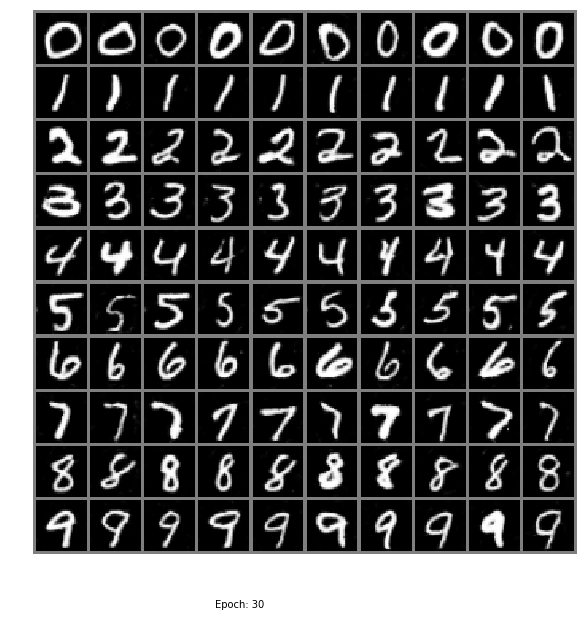

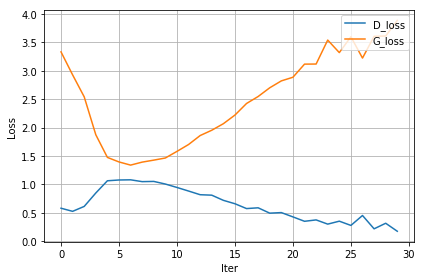

In [9]:
from model_C import Generator, Discriminator

train(mnist_dataloader, epochs=30)

### Sub-Experiment 4

Now, train aconditional GAN with fully convolutional generator and densely connected discriminator.

<img src="./images/cGAN_disc.png"  >

Generator :(100)+(10)   $\rightarrow$ (256,4,4)+(256,4,4)  $\rightarrow$ (512,4,4) $\rightarrow$ (256,8,8) $\rightarrow$ (128,16,16) $\rightarrow$ (1,32,32) 


Discriminator :1024 + 10 $\rightarrow$ (512)+(512) $\rightarrow$ 512 $\rightarrow$ 256  $\rightarrow$ 128  $\rightarrow$ 1

In [15]:
from model_C_alt import Generator, Discriminator

numClasses=10

In [37]:
def train(trainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numInputChannels, numClasses, numGenFilter, numOutputChannels)
    D = Discriminator(numOutputChannels, numClasses)
    
    #initialize weights 
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      1,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numInputChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    discRealInputClass = torch.zeros(batchSize,
                                     numClasses)
    
    discFakeInputClass = torch.zeros( batchSize,
                                      numClasses,
                                      1,
                                      1)    
    
    

    # to check the formation of image, we define a fixed noise vector
    numElementsNeededPerClass = 10
    
    fixedNoise = torch.randn(numElementsNeededPerClass*numClasses,
                             numInputChannels,
                             1,
                             1)
    
    # class from which the GAN should output a distribution
    fixedNoiseClass = torch.zeros(numElementsNeededPerClass*numClasses,
                                  numClasses,
                                  1,
                                  1)
    
    classIndex = torch.zeros(numElementsNeededPerClass,1)
    for i in range(numClasses-1):
        temp = torch.ones(numElementsNeededPerClass,1)+i
        classIndex = torch.cat([classIndex, temp], 0)
    
    fixedNoiseClass = fixedNoiseClass.squeeze().scatter_(1, classIndex.type(torch.LongTensor), 1)
    fixedNoiseClass = fixedNoiseClass.view(-1,
                                           numClasses,
                                           1,
                                           1)
    
    
    # can take the oneHot representation to feed into generator and discriminator directly from here
    oneHotGen = torch.zeros(numClasses, numClasses)
    oneHotGen = oneHotGen.scatter_(1, torch.LongTensor([i for i in range(numClasses)]).view(numClasses,1), 1).view(numClasses, numClasses, 1, 1)
    oneHotDisc = oneHotGen.squeeze()
      
    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discRealInputClass = discRealInputClass.cuda()
        discFakeInputClass = discFakeInputClass.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        fixedNoiseClass = fixedNoiseClass.cuda()
        
        
        
    fixedNoiseV = Variable(fixedNoise)
    fixedNoiseClassV = Variable(fixedNoiseClass)

    # loggers
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(trainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataClass = data
            
            # one-hot encoding for discriminator class input
            dataClass = oneHotDisc[dataClass]
            
            if cuda:
                dataInstance = dataInstance.cuda()
                dataClass = dataClass.cuda()
            
            
            #print discRealInput.shape, dataInstance.shape
            
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            discRealInputClass.copy_(dataClass)

            discRealInputV = Variable(discRealInput)
            discRealInputClassV = Variable(discRealInputClass)
            discRealLabelV = Variable(discRealLabel)
            
            discRealOutput = D(discRealInputV.view(batchSize,-1),
                               discRealInputClassV)
            
            
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            #  p=getProbDist(primaryInstanceList)
            dataFakeClass = torch.from_numpy(np.random.choice(numClasses, batchSize))
            discFakeInputClass = oneHotDisc[dataFakeClass]
            genFakeInputClass = oneHotGen[dataFakeClass]
            
            if cuda:
                discFakeInputClass = discFakeInputClass.cuda()
                genFakeInputClass = genFakeInputClass.cuda()

                
            discFakeInput.normal_(0,1)
            
            discFakeInputClassV= Variable(discFakeInputClass)
            genFakeInputClassV = Variable(genFakeInputClass)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            
            genFakeOutput = G(discFakeInputV,
                              genFakeInputClassV)
            genFakeOutput = genFakeOutput.view(batchSize,-1)
            
            # detach the graph prior to D. So what weights in G do not get updated
            #print genFakeOutput.data.shape, discFakeInputClassV.data.shape
            
            discFakeOutput = D(genFakeOutput.detach(),
                               discFakeInputClassV)
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutput.view(batchSize,-1),
                               discFakeInputClassV)
            
            genLossFake = lossFunction(discFakeOutput, 
                                       discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV,
                 fixedNoiseClassV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)

Epoch : [1/30] time: 15.20, loss_d: 1.274, loss_g: 0.750
Epoch : [2/30] time: 15.17, loss_d: 1.341, loss_g: 0.755
Epoch : [3/30] time: 16.39, loss_d: 1.344, loss_g: 0.753
Epoch : [4/30] time: 16.98, loss_d: 1.341, loss_g: 0.761
Epoch : [5/30] time: 16.94, loss_d: 1.334, loss_g: 0.763
Epoch : [6/30] time: 16.92, loss_d: 1.350, loss_g: 0.750
Epoch : [7/30] time: 16.96, loss_d: 1.330, loss_g: 0.777
Epoch : [8/30] time: 16.99, loss_d: 1.328, loss_g: 0.774
Epoch : [9/30] time: 16.93, loss_d: 1.302, loss_g: 0.801
Epoch : [10/30] time: 16.95, loss_d: 1.301, loss_g: 0.812
Epoch : [11/30] time: 16.94, loss_d: 1.320, loss_g: 0.796
Epoch : [12/30] time: 16.95, loss_d: 1.266, loss_g: 0.862
Epoch : [13/30] time: 16.90, loss_d: 1.324, loss_g: 0.780
Epoch : [14/30] time: 16.90, loss_d: 1.266, loss_g: 0.847
Epoch : [15/30] time: 16.95, loss_d: 1.264, loss_g: 0.873
Epoch : [16/30] time: 16.91, loss_d: 1.286, loss_g: 0.843
Epoch : [17/30] time: 16.93, loss_d: 1.278, loss_g: 0.850
Epoch : [18/30] time: 1

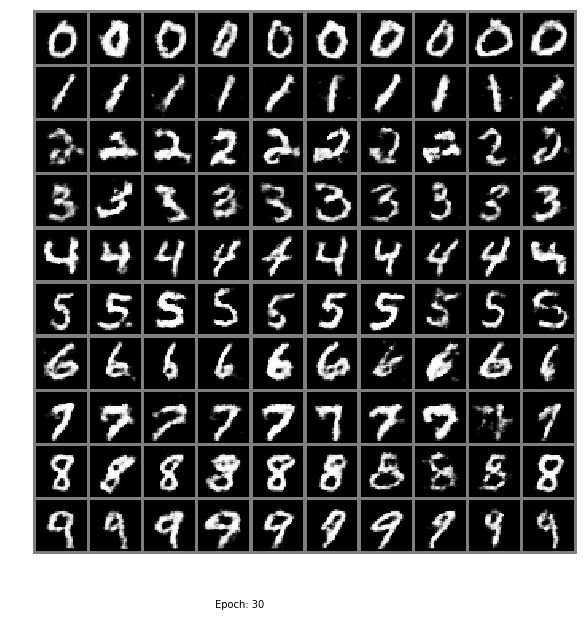

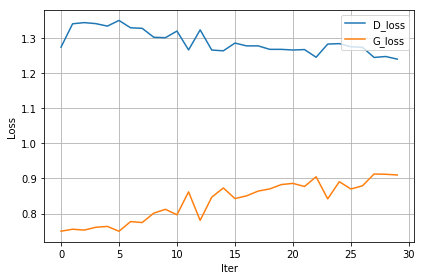

In [38]:
train(mnist_dataloader, epochs=30)